<a href="https://colab.research.google.com/github/columbia-data-club/meetings/blob/main/2023/Dataclub_November_13_Xarray_In_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- ![xarray Logo](http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png "xarray Logo")
 -->
<!-- ![A blue background with the SQLite logo and the words Data Club on it](https://raw.githubusercontent.com/columbia-data-club/meetings/main/assets/images/data-club-sqlite.png) -->
![A blue background with the Xarray logo and the words Data Club on it](assets/images/data-club-xarray.png)

# Xarray: labeled multi-dimensional arrays in Python

November 13, 2023

by [Roger Creel](https://rogercreel.com) for the [Columbia Data Club](https://github.com/columbia-data-club/), drawing heavily from the [Project Pythia tutorial](https://foundations.projectpythia.org/core/xarray/xarray-intro.html), the [Xarray documentation](https://docs.xarray.dev/en/stable/user-guide/index.html), and Ryan Abernathey's [Research Computing in Earth Sciences](https://rabernat.github.io/research_computing_2018/) course.

This notebook provides an introduction to Xarray, a Python library for working with labelled multi-dimensional arrays. A basic understanding of Python syntax (such as the one covered in the Data Club’s [Intro to Python video](https://youtu.be/l45rzo4MUHs) should suffice.

# Introduction to Xarray

---

## Overview

The examples in this tutorial focus on the fundamentals of working with gridded, labeled data using Xarray. Xarray works by introducing additional abstractions into otherwise ordinary data arrays. In this tutorial, we demonstrate the usefulness of these abstractions. The examples in this tutorial explain how the proper usage of Xarray abstractions generally leads to simpler, more robust code.

The following topics will be covered in this tutorial:

1. Create a `DataArray`, one of the core object types in Xarray
1. Understand how to use named coordinates and metadata in a `DataArray`
1. Combine individual `DataArrays` into a `Dataset`, the other core object type in Xarray
1. Subset, slice, and interpolate the data using named coordinates
1. Open netCDF data using Xarray
1. Basic subsetting and aggregation of a `Dataset`
1. Brief introduction to plotting with Xarray

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [NumPy Basics](../numpy/numpy-basics) | Necessary |  |
| [Intermediate NumPy](../numpy/intermediate-numpy) | Helpful | Familiarity with indexing and slicing arrays |
| [NumPy Broadcasting](../numpy/numpy-broadcasting) | Helpful | Familiarity with array arithmetic and broadcasting |
| [Introduction to Pandas](../pandas/pandas) | Helpful | Familiarity with labeled data |
| [Datetime](../datetime/datetime) | Helpful | Familiarity with time formats and the `timedelta` object |
| [Understanding of NetCDF](some-link-to-external-resource) | Helpful | Familiarity with metadata structure |


---

## Imports

In [ ]:
!pip install pythia_datasets
!pip install cftime
!pip install nc-time-axis
!pip install cartopy

In [ ]:
from datetime import timedelta

import numpy as np
import pandas as pd
import xarray as xr
from pythia_datasets import DATASETS

## Xarray primer
If you've worked with Python, you may have encountered [Pandas](https://pandas.pydata.org/pandas-docs/stable/).  Pandas is an excellent library for analyzing tabular "labeled data". [Xarray](http://xarray.pydata.org/en/stable/) is designed to make it easier to work with with _labeled multidimensional data_. By _multidimensional data_ (also often called _N-dimensional_), we mean data with many independent dimensions or axes. For example, we might represent Earth's surface temperature $T$ as a three dimensional variable

$$ T(x, y, t) $$

where $x$ and $y$ are spatial dimensions and and $t$ is time. By _labeled_, we mean data that has metadata associated with it describing the names and relationships between the variables. The cartoon below shows a "data cube" schematic dataset with temperature and preciptation sharing the same three dimensions, plus longitude and latitude as auxilliary coordinates.

![xarray data model](https://raw.githubusercontent.com/pydata/xarray/master/doc/_static/dataset-diagram.png)

Xarray's interface is based largely on the netCDF data model (variables, attributes, and dimensions), but it goes beyond the traditional netCDF interfaces in order to provide additional useful functionality, similar to netCDF-java's [Common Data Model (CDM)](https://docs.unidata.ucar.edu/netcdf-java/current/userguide/common_data_model_overview.html).



### Xarray data structures

Like Pandas, xarray has two fundamental data structures:
* **`DataArray`**
    
     + A multi-dimensional array with labeled or named dimensions. `DataArray` objects add metadata such as dimension names, coordinates, and attributes (defined below) to underlying “unlabeled” data structures such as numpy and Dask arrays. If its optional name property is set, it is a named `DataArray`.

* **`Dataset`**

    + A dict-like collection of `DataArray` objects with aligned dimensions. Thus, most operations that can be performed on the dimensions of a single `DataArray` can be performed on a `Dataset`. Datasets have data variables, dimensions, coordinates, and attributes.

#### DataArray

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

#### DataSet

A dataset is simply an object containing multiple DataArrays indexed by variable name


## We just used a bunch of terminology.  What are `Variables`, `Dimensions`, and `Coordinates`?


#### Variable
A NetCDF-like variable consisting of dimensions, data, and attributes which describe a single array. The main functional difference between variables and numpy arrays is that numerical operations on variables implement array broadcasting by dimension name. Each `DataArray` has an underlying variable that can be accessed via `arr.variable`. However, a variable is not fully described outside of either a `Dataset` or a `DataArray`.

#### Dimension
In mathematics, the dimension of data is loosely the number of degrees of freedom for it. A _dimension axis_ is a set of all points in which all but one of these degrees of freedom is fixed. We can think of each dimension axis as having a name, for example the “x dimension”. In xarray, a DataArray object’s _dimensions_ are its named dimension axes, and the name of the i-th dimension is `arr.dims[i]`. If an array is created without dimension names, the default dimension names are `dim_0`, `dim_1`, and so forth.

#### Coordinate

An array that labels a dimension or set of dimensions of another `DataArray`. In the usual one-dimensional case, the coordinate array’s values can loosely be thought of as tick labels along a dimension. We distinguish Dimension coordinate vs. Non-dimension coordinate and Indexed coordinate vs. Non-indexed coordinate. A coordinate named `x` can be retrieved from `arr.coords[x]`. A `DataArray` can have more coordinates than dimensions because a single dimension can be labeled by multiple coordinate arrays. However, only one coordinate array can be a assigned as a particular dimension’s dimension coordinate array. As a consequence, `len(arr.dims) <= len(arr.coords)` in general.

# Let's play with code!

#### Generate a random numpy array

We first create a numpy array, holding random placeholder data of temperatures in Kelvin:

In [ ]:
data = 283 + 5 * np.random.randn(5, 3, 4)
data

#### Wrap the array: first attempt

To wrap the NumPy array into a `DataArray`, we simply use the `DataArray` method of Xarray, passing the NumPy array we just created:

In [ ]:
temp = xr.DataArray(data)
temp

Note two things:

1. Since NumPy arrays have no dimension names, our new `DataArray` takes on placeholder dimension names, in this case `dim_0`, `dim_1`, and `dim_2`.  We'll next see how to add more meaningful dimension names.
2. Running the above example in Google Colab generates a rich display of the data contained in our `DataArray`. This display comes with many ways to explore the data; for example, clicking the array symbol expands or collapses the data view.

#### Assign dimension names

To make use of Xarray's powerful capacity for named dimensions, we need more useful dimension names. We can generate these names when creating a `DataArray` by passing an ordered list of names to the `DataArray` method, using the keyword argument `dims`:

In [ ]:
temp = xr.DataArray(data, dims=['time', 'lat', 'lon'])
temp

This `DataArray` is already an improvement over a NumPy array; the `DataArray` contains names for each of the dimensions (or axes in NumPy parlance). An additional improvement is the association of coordinate-value arrays with data upon creation of a `DataArray`. In the next example, we illustrate the creation of NumPy arrays representing the coordinate values for each dimension of the `DataArray`, and how to associate these coordinate arrays with the data in our `DataArray`.

### Create a `DataArray` with named Coordinates

#### Make time and space coordinates

We use [Pandas](../pandas) to create an array of [datetime data](../datetime). In a later example, we will us this array to add a named coordinate, called `time`, to a `DataArray`.

In [ ]:
times = pd.date_range('2018-01-01', periods=5)
times

Before associating coordinates with our `DataArray`, we must also create latitude and longitude coordinate arrays.  In these examples, we use placeholder data, and create the arrays in NumPy format:

In [ ]:
lons = np.linspace(-120, -60, 4)
lats = np.linspace(25, 55, 3)

#### Initialize the `DataArray` with complete coordinate info

We now create a new `DataArray`. We use the `dims` keyword argument to specify the dimension names and the coordinate arrays using the `coords` keyword argument:

In [ ]:
temp = xr.DataArray(data, coords=[times, lats, lons], dims=['time', 'lat', 'lon'])
temp

#### Set useful attributes

As described above, `DataArrays` have a built-in container for attribute metadata. These attributes are similar to those in netCDF files, and are added to a `DataArray` using its `attrs` method:

In [ ]:
temp.attrs['units'] = 'kelvin'
temp.attrs['standard_name'] = 'air_temperature'

temp

#### Issues with preservation of attributes

When a mathematical operation is performed on a `DataArray`, all the coordinate arrays remain attached to the `DataArray`, but any attribute metadata assigned is lost. Attributes are removed in this way due to the fact that they may not convey correct or appropriate metadata after an arbitrary arithmetic operation. We first convert our DataArray values from Kelvin to degrees Celsius:

In [ ]:
temp_in_celsius = temp - 273.15
temp_in_celsius

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[ 9.26928305,  5.05432116, 18.60988143,  9.85484071],
        [ 7.91202933,  7.40089667, 11.32311214,  2.63385227],
        [ 7.37802977,  9.86281187, 11.68504146, 10.82747639]],

       [[ 9.09249904, 15.53390458,  6.42314694, 17.17979384],
        [ 5.30472533,  7.91486998,  2.20918542, 12.69393362],
        [ 9.80122232,  5.05034481, 16.41453845,  6.19191428]],

       [[10.74495497, 12.82242593, -1.44145682,  6.99506682],
        [ 9.17182814, 11.65101626, 15.45860769,  3.43341233],
        [ 8.8907853 ,  8.22834628, 15.0036593 ,  0.19536579]],

       [[15.83868094, 16.57411195,  8.7203999 ,  4.91496805],
        [12.64743078, 10.35255489, -1.95636857, 11.0593027 ],
        [ 4.79850714,  9.10698675,  3.32451494, 14.6318351 ]],

       [[ 9.68463406,  9.67813675, 17.53572583,  6.99331676],
        [ 5.59432624, 19.10576276,  5.62422313,  9.31896084],
        [-5.5458601 ,  2.66973765, 18.2895084 , -1.38190452]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0

In addition, if you need more details on how Xarray handles metadata, you can review this [documentation page](http://xarray.pydata.org/en/stable/getting-started-guide/faq.html#approach-to-metadata).

### The `Dataset`: a container for `DataArray`s with shared coordinates

Along with the `DataArray`, the other main object type in Xarray is the `Dataset`.  `Datasets` are containers similar to Python dictionaries; each `Dataset` can hold one or more `DataArrays`. In addition, the `DataArrays` contained in a `Dataset` can share coordinates, although this behavior is optional.  (For more information, see the [official documentation page](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataset).)

`Dataset` objects are most often created by loading data from a data file, but here we will create a `Dataset` from two `DataArrays`. We will use our existing temperature `DataArray` for one of these `DataArrays`; the other one is created in the next example.

In addition, both of these `DataArrays` will share coordinate axes. Therefore, the next example will also illustrate the usage of common coordinate axes across `DataArrays` in a `Dataset`.

#### Create a pressure `DataArray` using the same coordinates

We now create a `DataArray` object to hold pressure data. This new `DataArray` is set up in a very similar fashion to the temperature `DataArray` created above.

In [ ]:
pressure_data = 1000.0 + 5 * np.random.randn(5, 3, 4)
pressure = xr.DataArray(
    pressure_data, coords=[times, lats, lons], dims=['time', 'lat', 'lon']
)
pressure.attrs['units'] = 'hPa'
pressure.attrs['standard_name'] = 'air_pressure'

pressure

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[1003.16890841, 1003.37231837, 1002.77981474, 1002.08057032],
        [ 996.23001697, 1001.85673341, 1000.87876604, 1007.34580019],
        [1000.8376087 ,  994.28440754, 1003.59872628,  997.72098797]],

       [[ 997.39129095,  992.40039513,  998.32389273, 1000.45010406],
        [1003.602489  ,  996.5767467 , 1002.15070898,  999.67173402],
        [ 993.51241925,  997.23006549, 1000.95054819,  999.70856863]],

       [[1000.70290688,  999.11032351, 1002.97761824, 1003.74392626],
        [ 997.16147558, 1008.31721413,  998.12848806, 1002.96278474],
        [ 992.80216226,  999.93776502,  992.00842646,  994.64431168]],

       [[1005.92499718, 1003.06347368, 1000.33382531,  998.30961276],
        [ 998.04775531,  996.98126959,  997.42539622,  996.23476659],
        [ 997.90644749,  994.65560094,  999.47458604, 1000.49494615]],

       [[1003.96813694, 1000.73023317,  995.64680538, 1011.28256152],
        [1002.33036093, 1002.67012191, 1003.20594016,  996.9754778 ],
        [1006.61251857, 1006.84693888, 1003.47743284, 1006.43507809]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

#### Create a `Dataset` object

Before we can create a `Dataset` object, we must first name each of the `DataArray` objects that will be added to the new `Dataset`.  We can do this by seting up a Python dictionary, then passing this dictionary to the `Dataset` method using the keyword argument `data_vars`. This creates a new `Dataset` containing both of our `DataArrays`.

In [ ]:
ds = xr.Dataset(data_vars={'Temperature': temp, 'Pressure': pressure})
ds

<xarray.Dataset>
Dimensions:      (time: 5, lat: 3, lon: 4)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat          (lat) float64 25.0 40.0 55.0
  * lon          (lon) float64 -120.0 -100.0 -80.0 -60.0
Data variables:
    Temperature  (time, lat, lon) float64 282.4 278.2 291.8 ... 291.4 271.8
    Pressure     (time, lat, lon) float64 1.003e+03 1.003e+03 ... 1.006e+03

The new `Dataset` object knows that both `DataArrays` share the same coordinate axes.

#### Access Data variables and Coordinates in a `Dataset`

How do we retrieving `DataArrays` from a `Dataset`?

Option A: via the "dot" notation.

In [ ]:
ds.Pressure

<xarray.DataArray 'Pressure' (time: 5, lat: 3, lon: 4)>
array([[[1003.16890841, 1003.37231837, 1002.77981474, 1002.08057032],
        [ 996.23001697, 1001.85673341, 1000.87876604, 1007.34580019],
        [1000.8376087 ,  994.28440754, 1003.59872628,  997.72098797]],

       [[ 997.39129095,  992.40039513,  998.32389273, 1000.45010406],
        [1003.602489  ,  996.5767467 , 1002.15070898,  999.67173402],
        [ 993.51241925,  997.23006549, 1000.95054819,  999.70856863]],

       [[1000.70290688,  999.11032351, 1002.97761824, 1003.74392626],
        [ 997.16147558, 1008.31721413,  998.12848806, 1002.96278474],
        [ 992.80216226,  999.93776502,  992.00842646,  994.64431168]],

       [[1005.92499718, 1003.06347368, 1000.33382531,  998.30961276],
        [ 998.04775531,  996.98126959,  997.42539622,  996.23476659],
        [ 997.90644749,  994.65560094,  999.47458604, 1000.49494615]],

       [[1003.96813694, 1000.73023317,  995.64680538, 1011.28256152],
        [1002.33036093, 1002.67012191, 1003.20594016,  996.9754778 ],
        [1006.61251857, 1006.84693888, 1003.47743284, 1006.43507809]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

Option B: through a dictionary syntax.

In [ ]:
ds['Pressure']

<xarray.DataArray 'Pressure' (time: 5, lat: 3, lon: 4)>
array([[[1003.16890841, 1003.37231837, 1002.77981474, 1002.08057032],
        [ 996.23001697, 1001.85673341, 1000.87876604, 1007.34580019],
        [1000.8376087 ,  994.28440754, 1003.59872628,  997.72098797]],

       [[ 997.39129095,  992.40039513,  998.32389273, 1000.45010406],
        [1003.602489  ,  996.5767467 , 1002.15070898,  999.67173402],
        [ 993.51241925,  997.23006549, 1000.95054819,  999.70856863]],

       [[1000.70290688,  999.11032351, 1002.97761824, 1003.74392626],
        [ 997.16147558, 1008.31721413,  998.12848806, 1002.96278474],
        [ 992.80216226,  999.93776502,  992.00842646,  994.64431168]],

       [[1005.92499718, 1003.06347368, 1000.33382531,  998.30961276],
        [ 998.04775531,  996.98126959,  997.42539622,  996.23476659],
        [ 997.90644749,  994.65560094,  999.47458604, 1000.49494615]],

       [[1003.96813694, 1000.73023317,  995.64680538, 1011.28256152],
        [1002.33036093, 1002.67012191, 1003.20594016,  996.9754778 ],
        [1006.61251857, 1006.84693888, 1003.47743284, 1006.43507809]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

## Subsetting and selection by coordinate values

Much of the power of labeled coordinates comes from the ability to select data based on coordinate names and values instead of array indices.

### NumPy-like selection

Let's extract all our spatial data for a single date; in this case, January 2, 2018. We'll retrieve spatial data using index selection, as with a NumPy array:

In [ ]:
indexed_selection = temp[1, :, :]  # Index 1 along axis 0 is the time slice we want...
indexed_selection

<xarray.DataArray (lat: 3, lon: 4)>
array([[282.24249904, 288.68390458, 279.57314694, 290.32979384],
       [278.45472533, 281.06486998, 275.35918542, 285.84393362],
       [282.95122232, 278.20034481, 289.56453845, 279.34191428]])
Coordinates:
    time     datetime64[ns] 2018-01-02
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

Here we see a major shortcoming of index selection: to retrieve the correct data, you need knowledge of the `DataArray` axes, including the axes' order and meaning.

By using named coordinates, we can avoid this burden.

### Selecting with `.sel()`

Let's now select data based on coordinate values using the `.sel()` method. This method takes one or more named coordinates in keyword-argument format, and returns data matching the coordinates.

In [ ]:
named_selection = temp.sel(time='2018-01-02')
named_selection

<xarray.DataArray (lat: 3, lon: 4)>
array([[282.24249904, 288.68390458, 279.57314694, 290.32979384],
       [278.45472533, 281.06486998, 275.35918542, 285.84393362],
       [282.95122232, 278.20034481, 289.56453845, 279.34191428]])
Coordinates:
    time     datetime64[ns] 2018-01-02
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

This method yields the same result as the index selection, however:
- we can know nothing about how the array was created or stored
- our code is agnostic about how many dimensions we are dealing with
- the intended meaning of our code is clearer

### Approximate selection and interpolation

When working with temporal and spatial data, it is a common practice to sample data close to the coordinate points in a dataset. Let's examine some common techniques.

#### Nearest-neighbor sampling

We could want to sample a temporal data point within 2 days of the date `2018-01-07`. Since the final date on our `DataArray`'s temporal axis is `2018-01-05`, this is an appropriate problem.

We can use the `.sel()` method to perform nearest-neighbor sampling, by setting the `method` keyword argument to 'nearest'. We can also provide a `tolerance` argument; with temporal data, this is a `timedelta` object.

In [ ]:
temp.sel(time='2018-01-07', method='nearest', tolerance=timedelta(days=2))

<xarray.DataArray (lat: 3, lon: 4)>
array([[282.83463406, 282.82813675, 290.68572583, 280.14331676],
       [278.74432624, 292.25576276, 278.77422313, 282.46896084],
       [267.6041399 , 275.81973765, 291.4395084 , 271.76809548]])
Coordinates:
    time     datetime64[ns] 2018-01-05
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

We see that `.sel` returned the data at the temporal value corresponding to the date `2018-01-05`.

#### Interpolation

In this example, we are trying to extract a timeseries for Boulder, CO (40°N latitude, 105°W longitude). Our `DataArray` does not contain a longitude data value of -105, so we must interpolate between data points.

The `.interp()` method lets us retrieve data from any lat and lon by means of interpolation. This method uses coordinate-value selection, similarly to `.sel()`.  (For more info on the `.interp()` method, see the documentation [here](http://xarray.pydata.org/en/stable/interpolation.html).)

In [ ]:
temp.interp(lon=-105, lat=40)

<xarray.DataArray (time: 5)>
array([280.67867984, 280.41233382, 284.18121923, 284.07627386,
       288.87790363])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-05
    lon      int64 -105
    lat      int64 40
Attributes:
    units:          kelvin
    standard_name:  air_temperature

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Xarray uses the SciPy package to interpolate. You can learn more about SciPy from the <a href="https://scipy.org/">official documentation</a>.
</div>

### Slicing along coordinates

It is useful to select a range, or _slice_, of data along one or more coordinates.  To understand this process, you must first understand Python `slice` objects (see the official [Python slice documentation](https://docs.python.org/3/library/functions.html#slice)). Once you are proficient using `slice` objects, you can create slices of data by passing `slice` objects to the `.sel` method:

In [ ]:
temp.sel(
    time=slice('2018-01-01', '2018-01-03'), lon=slice(-110, -70), lat=slice(25, 45)
)

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[278.20432116, 291.75988143],
        [280.55089667, 284.47311214]],

       [[288.68390458, 279.57314694],
        [281.06486998, 275.35918542]],

       [[285.97242593, 271.70854318],
        [284.80101626, 288.60860769]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 25.0 40.0
  * lon      (lon) float64 -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    The <code>slice</code> function uses the argument order <code>(start, stop[, step])</code>, where <code>step</code> is optional.
</div>

Because we are now working with a slice of data, the lengths of our coordinate axes have been shortened.

### One more selection method: `.loc`

In addition to using the `sel()` method to select data from a `DataArray`, you can also use the `.loc` attribute.  Every `DataArray` has a `.loc` attribute; in order to leverage this attribute to select data, you can specify a coordinate value in square brackets:

In [ ]:
temp.loc['2018-01-02']

<xarray.DataArray (lat: 3, lon: 4)>
array([[282.24249904, 288.68390458, 279.57314694, 290.32979384],
       [278.45472533, 281.06486998, 275.35918542, 285.84393362],
       [282.95122232, 278.20034481, 289.56453845, 279.34191428]])
Coordinates:
    time     datetime64[ns] 2018-01-02
  * lat      (lat) float64 25.0 40.0 55.0
  * lon      (lon) float64 -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

This selection technique is similar to NumPy's index-based selection:
```
temp[1,:,:]
```
However, this technique also resembles the `.sel()` method's fully label-based selection functionality.

Here we see a disadvantage of using the `.loc` attribute.  Namely, we specify the values for each coordinate, but cannot specify the dimension names; therefore, the dimensions must be specified in the correct order, and this order must already be known:

In [ ]:
temp.loc['2018-01-01':'2018-01-03', 25:45, -110:-70]

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[278.20432116, 291.75988143],
        [280.55089667, 284.47311214]],

       [[288.68390458, 279.57314694],
        [281.06486998, 275.35918542]],

       [[285.97242593, 271.70854318],
        [284.80101626, 288.60860769]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 25.0 40.0
  * lon      (lon) float64 -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

Here we see a useful advantage of using the `.loc` attribute: you can specify data slices using a syntax similar to NumPy in addition to, or instead of, using the slice function:

In [ ]:
temp.loc['2018-01-01':'2018-01-03', slice(25, 45), -110:-70]

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[278.20432116, 291.75988143],
        [280.55089667, 284.47311214]],

       [[288.68390458, 279.57314694],
        [281.06486998, 275.35918542]],

       [[285.97242593, 271.70854318],
        [284.80101626, 288.60860769]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 25.0 40.0
  * lon      (lon) float64 -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

The arguments to `.loc` must be in the order of the `DataArray`'s dimensions.  Attempting to slice data without ordering arguments properly can cause errors:

In [ ]:
# This will generate an error
# temp.loc[-110:-70, 25:45,'2018-01-01':'2018-01-03']

## Opening netCDF data

Xarray has close ties to the netCDF data format; as such, netCDF was chosen as the premier data file format for Xarray. Hence, Xarray can easily open netCDF datasets, provided they conform to certain limitations (for example, 1-dimensional coordinates).

### Access netCDF data with `xr.open_dataset`

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    The data file for this example, <code>NARR_19930313_0000.nc</code>, is retrieved from Project Pythia's custom example data library.  The <code>DATASETS</code> class imported at the top of this page contains a <code>.fetch()</code> method, which retrieves, downloads, and caches a Pythia example data file.
</div>

In [ ]:
filepath = DATASETS.fetch('NARR_19930313_0000.nc')

Once we have a valid path to a data file that Xarray knows how to read, we can open the data file and load it into Xarray; this is done by passing the path to Xarray's `open_dataset` method, as shown below:

In [ ]:
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:                       (time1: 1, isobaric1: 29, y: 119, x: 268)
Coordinates:
  * time1                         (time1) datetime64[ns] 1993-03-13
  * isobaric1                     (isobaric1) float32 100.0 125.0 ... 1e+03
  * y                             (y) float32 -3.117e+03 -3.084e+03 ... 714.1
  * x                             (x) float32 -3.324e+03 ... 5.343e+03
Data variables:
    u-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 ...
    LambertConformal_Projection   int32 ...
    lat                           (y, x) float64 ...
    lon                           (y, x) float64 ...
    Geopotential_height_isobaric  (time1, isobaric1, y, x) float32 ...
    v-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 ...
    Temperature_isobaric          (time1, isobaric1, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  North American Regional Reanalysis ...
    GRIB_table_version:                   0,131
    Generating_process_or_model:          North American Regional Reanalysis ...
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    History:                              Translated to CF-1.0 Conventions by...
    geospatial_lat_min:                   10.753308882144761
    geospatial_lat_max:                   46.8308828962289
    geospatial_lon_min:                   -153.88242040519995
    geospatial_lon_max:                   -42.666108129242815

### Subsetting the `Dataset`

Xarray's `open_dataset()` method returns a `Dataset` object, which must then be assigned to a variable; in this case, we call the variable `ds`. Once the netCDF dataset is loaded into an Xarray `Dataset`, we can pull individual `DataArrays` out of the `Dataset`.  In this example, we retrieve isobaric pressure data:

In [ ]:
ds.isobaric1

<xarray.DataArray 'isobaric1' (isobaric1: 29)>
array([ 100.,  125.,  150.,  175.,  200.,  225.,  250.,  275.,  300.,  350.,
        400.,  450.,  500.,  550.,  600.,  650.,  700.,  725.,  750.,  775.,
        800.,  825.,  850.,  875.,  900.,  925.,  950.,  975., 1000.],
      dtype=float32)
Coordinates:
  * isobaric1  (isobaric1) float32 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03
Attributes:
    units:                   hPa
    long_name:               Isobaric surface
    positive:                down
    Grib_level_type:         100
    _CoordinateAxisType:     Pressure
    _CoordinateZisPositive:  down

We can also use dictionary syntax to select specific `DataArrays`; in this case, we would write `ds['isobaric1']`.)

Many of the subsetting operations usable on `DataArrays` can also be used on `Datasets`.  However, when used on `Datasets`, these operations are performed on every `DataArray` in the `Dataset`:

In [ ]:
ds_1000 = ds.sel(isobaric1=1000.0)
ds_1000

<xarray.Dataset>
Dimensions:                       (time1: 1, y: 119, x: 268)
Coordinates:
  * time1                         (time1) datetime64[ns] 1993-03-13
    isobaric1                     float32 1e+03
  * y                             (y) float32 -3.117e+03 -3.084e+03 ... 714.1
  * x                             (x) float32 -3.324e+03 ... 5.343e+03
Data variables:
    u-component_of_wind_isobaric  (time1, y, x) float32 ...
    LambertConformal_Projection   int32 ...
    lat                           (y, x) float64 ...
    lon                           (y, x) float64 ...
    Geopotential_height_isobaric  (time1, y, x) float32 ...
    v-component_of_wind_isobaric  (time1, y, x) float32 ...
    Temperature_isobaric          (time1, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  North American Regional Reanalysis ...
    GRIB_table_version:                   0,131
    Generating_process_or_model:          North American Regional Reanalysis ...
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    History:                              Translated to CF-1.0 Conventions by...
    geospatial_lat_min:                   10.753308882144761
    geospatial_lat_max:                   46.8308828962289
    geospatial_lon_min:                   -153.88242040519995
    geospatial_lon_max:                   -42.666108129242815

As shown above, the subsetting operation performed on the `Dataset` returned a new `Dataset`.  If only a single `DataArray` is needed from this new `Dataset`, it can be retrieved using the familiar dot notation:

In [ ]:
ds_1000.Temperature_isobaric

<xarray.DataArray 'Temperature_isobaric' (time1: 1, y: 119, x: 268)>
[31892 values with dtype=float32]
Coordinates:
  * time1      (time1) datetime64[ns] 1993-03-13
    isobaric1  float32 1e+03
  * y          (y) float32 -3.117e+03 -3.084e+03 -3.052e+03 ... 681.6 714.1
  * x          (x) float32 -3.324e+03 -3.292e+03 ... 5.311e+03 5.343e+03
Attributes:
    long_name:           Temperature @ Isobaric surface
    units:               K
    description:         Temperature
    grid_mapping:        LambertConformal_Projection
    Grib_Variable_Id:    VAR_7-15-131-11_L100
    Grib1_Center:        7
    Grib1_Subcenter:     15
    Grib1_TableVersion:  131
    Grib1_Parameter:     11
    Grib1_Level_Type:    100
    Grib1_Level_Desc:    Isobaric surface

### Aggregation operations

You can use named dimensions in an Xarray `Dataset` to manually slice and index data.  However, these dimension names also allow you can use them to specify dimensions to aggregate on. Of the many different aggregation operations available; in the, we focus on `std` (standard deviation).

In [ ]:
u_winds = ds['u-component_of_wind_isobaric']
u_winds.std(dim=['x', 'y'])

<xarray.DataArray 'u-component_of_wind_isobaric' (time1: 1, isobaric1: 29)>
array([[ 8.673963 , 10.212325 , 11.556413 , 12.254429 , 13.372146 ,
        15.472462 , 16.091969 , 15.846294 , 15.195834 , 13.936979 ,
        12.93888  , 12.060708 , 10.972139 ,  9.722328 ,  8.853286 ,
         8.257241 ,  7.679721 ,  7.4516497,  7.2352104,  7.039894 ,
         6.883371 ,  6.7821493,  6.7088237,  6.6865997,  6.7247376,
         6.745023 ,  6.6859775,  6.5107226,  5.972262 ]], dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 1993-03-13
  * isobaric1  (isobaric1) float32 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Aggregations in NumPy operate over axes specified by numeric values. However, with Xarray objects, aggregation dimensions are instead specified through a list passed to the <code>dim</code> keyword argument.
</div>

We'll next compute a mean temperature profile, defined as temperature as a function of pressure, over Colorado.  For the purposes of these examples, the bounds of Colorado are defined as follows:
 * x: -182km to 424km
 * y: -1450km to -990km
    
This dataset uses a Lambert Conformal projection; therefore, the data values shown above are projected to specific latitude and longitude values. These latitude and longitude values are 37°N to 41°N and 102°W to 109°W. Using the original data values and the `mean` aggregation function as shown below yields the following mean temperature profile data:

In [ ]:
temps = ds.Temperature_isobaric
co_temps = temps.sel(x=slice(-182, 424), y=slice(-1450, -990))
prof = co_temps.mean(dim=['x', 'y'])
prof

<xarray.DataArray 'Temperature_isobaric' (time1: 1, isobaric1: 29)>
array([[215.078  , 215.76935, 217.243  , 217.82663, 215.83487, 216.10933,
        219.99902, 224.66118, 228.80576, 234.88701, 238.78503, 242.66309,
        246.44807, 249.26636, 250.84995, 253.37354, 257.0429 , 259.08398,
        260.97955, 262.98364, 264.82138, 266.5198 , 268.22467, 269.7471 ,
        271.18216, 272.66815, 274.13037, 275.54718, 276.97675]],
      dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 1993-03-13
  * isobaric1  (isobaric1) float32 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03

## Plotting with Xarray

Xarray greatly simplifies plotting of data stored as `DataArrays` and `Datasets`. Many common plot elements, such as axis labels, are automatically generated and optimized for the data being plotted.  

### Simple visualization with `.plot()`

Similarly to [Pandas](../pandas/pandas), Xarray includes a built-in plotting interface, which makes use of [Matplotlib](../matplotlib) behind the scenes. To use this interface, you can call the `.plot()` method, which is included in every `DataArray`.

Let's create a basic plot from a `DataArray` via the `prof` `DataArray` defined above, which contains a Colorado mean temperature profile.

In [ ]:
prof.plot()

Xarray has generated a line plot, which uses the mean temperature profile and the `'isobaric'` coordinate variable as axes. In addition, the axis labels and unit information have been read automatically from the `DataArray`'s metadata.

### Customizing the plot

Let's next  customize the air temperature profile plot created above by making two changes:
- swap the axes, so that the Y (vertical) axis corresponds to isobaric levels
- invert the Y axis to match the model of air pressure decreasing at higher altitudes

We can make these changes by adding certain keyword arguments when calling `.plot()`, as shown below:

In [ ]:
prof.plot(y="isobaric1", yincrease=False)

### Plotting 2-D data

We used `.plot()` to generate a plot from 1-D data, and the result was a line plot. In this section, we illustrate plotting of 2-D data.

Now we illustrate basic plotting of a 2-D array:

In [ ]:
temps.sel(isobaric1=1000).plot()

We made the figure above via Matplotlib's `pcolormesh` method, which Xarray's `plot` method automatically called because Xarray recognized that the `DataArray` object contained two distinct coordinate variables.

The plot is a map of air temperatures over North America on the 1000 hPa isobaric surface. If a different map projection or added geographic features are needed, we could easily modify the plot using [Cartopy](../cartopy).

# Part 2: Working with Data

## Data Setup

This tutorial mostly uses a single dataset: monthly sea surface temperature (SST, call 'tos' here) data, obtained from the Community Earth System Model v2 (CESM2), here retrieved from the Pythia example data repository. Let's look at the process of retrieving this Global Climate Model dataset:

In [ ]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
ds = xr.open_dataset(filepath)
ds

/usr/local/lib/python3.10/dist-packages/xarray/conventions.py:431: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

## Arithmetic Operations

In a similar fashion to NumPy arrays, performing an arithmetic operation on a `DataArray` automatically performs the operation on all array values; this is known as vectorization. For instance, with vectorization we can convert air temperature data from degrees Celsius to Kelvin:

In [ ]:
ds.tos + 273.15

<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [271.3552 , 271.3553 , 271.3554 , ..., 271.35495, 271.355  ,
         271.3551 ],
        [271.36005, 271.36014, 271.36023, ..., 271.35986, 271.35992,
         271.36   ],
        [271.36447, 271.36453, 271.3646 , ..., 271.3643 , 271.36435,
         271.3644 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [271.40677, 271.40674, 271.4067 , ..., 271.40695, 271.4069 ,
         271.40683],
        [271.41296, 271.41293, 271.41293, ..., 271.41306, 271.413  ,
         271.41296],
        [271.41772, 271.41772, 271.41772, ..., 271.41766, 271.4177 ,
         271.4177 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [271.39386, 271.39383, 271.3938 , ..., 271.39407, 271.394  ,
         271.39392],
        [271.39935, 271.39932, 271.39932, ..., 271.39948, 271.39944,
         271.39938],
        [271.40372, 271.40372, 271.40375, ..., 271.4037 , 271.4037 ,
         271.40372]]], dtype=float32)
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

We can perform other arithmetic operations on `DataArrays`, for instance squaring the original Celsius values of our air temperature data:

In [ ]:
ds.tos**2

<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [3.2213385, 3.2209656, 3.220537 , ..., 3.2221622, 3.221913 ,
         3.2216525],
        [3.203904 , 3.203617 , 3.2032912, ..., 3.2045207, 3.2043478,
         3.2041442],
        [3.1881146, 3.1879027, 3.1876712, ..., 3.188714 , 3.1885312,
         3.1883302]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [3.0388296, 3.0389647, 3.0390673, ..., 3.038165 , 3.0383828,
         3.0386322],
        [3.0173173, 3.0173445, 3.0173297, ..., 3.0169601, 3.0171173,
         3.0172386],
        [3.000791 , 3.0007784, 3.0007539, ..., 3.000933 , 3.000896 ,
         3.0008452]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [3.0839543, 3.0841148, 3.0842566, ..., 3.0832636, 3.0834875,
         3.0837412],
        [3.064733 , 3.0648024, 3.0648358, ..., 3.0642793, 3.0644639,
         3.0646174],
        [3.0494578, 3.0494475, 3.0494263, ..., 3.049596 , 3.0495603,
         3.0495107]]], dtype=float32)
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

## Aggregation Methods

Aggregation is a common practice in data analysis. Aggregation means reducing data through methods such as `sum()`, `mean()`, `median()`, `min()`, and `max()`. We'll next demonstrate correct usage of a select group of aggregation methods:

In [ ]:
ds.tos.mean()

<xarray.DataArray 'tos' ()>
array(14.250171, dtype=float32)

Notice that because we did not specify the `dim` keyword argument, the function was applied over all of the dataset's dimensions. In other words, the aggregation method computed the mean of every element of the temperature dataset across time and space. However, if a dimension name is used with the `dim` keyword argument, the aggregation method computes an aggregation along the single dimension. We next use aggregation to calculate the temporal mean across all spatial data by providing the dimension name `'time'` to the `dim` keyword argument:

In [ ]:
ds.tos.mean(dim='time').plot(size=7);

There are other combinations of aggregation methods and dimensions on which to perform these methods, for instannce computing the temporal minimum:

In [ ]:
ds.tos.min(dim=['time'])

<xarray.DataArray 'tos' (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.8083605, -1.8083031, -1.8082187, ..., -1.8083988, -1.8083944,
        -1.8083915],
       [-1.8025414, -1.8024837, -1.8024155, ..., -1.8026428, -1.8026177,
        -1.8025846],
       [-1.7984415, -1.7983989, -1.7983514, ..., -1.7985678, -1.7985296,
        -1.7984871]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

Since this dataset contains no altitude data, computes the spatial sum requires only passing latitude and longitude to the method.

In [ ]:
ds.tos.sum(dim=['lat', 'lon'])

<xarray.DataArray 'tos' (time: 180)>
array([603767.  , 607702.5 , 603976.5 , 599373.56, 595119.94, 595716.75,
       598177.3 , 600670.6 , 597825.56, 591869.  , 590507.7 , 597189.2 ,
       605954.06, 609151.  , 606868.9 , 602329.9 , 599465.75, 601205.5 ,
       605144.4 , 608588.5 , 604046.9 , 598927.75, 597519.75, 603876.9 ,
       612424.44, 615765.2 , 612615.44, 606310.6 , 602034.4 , 600784.9 ,
       602013.5 , 603142.2 , 598850.9 , 591917.44, 589234.56, 596162.5 ,
       602942.06, 607196.9 , 604928.2 , 601735.6 , 599011.8 , 599490.9 ,
       600801.44, 602786.94, 598867.2 , 594081.8 , 593736.25, 598995.6 ,
       607285.25, 611901.06, 609562.75, 603527.3 , 600215.4 , 601372.6 ,
       604144.5 , 605376.75, 601256.2 , 595245.2 , 594002.06, 600490.4 ,
       611878.6 , 616563.  , 613050.8 , 605734.  , 600808.75, 600898.06,
       603930.56, 605644.7 , 599917.5 , 592048.06, 590082.8 , 596950.7 ,
       607701.94, 610844.7 , 609509.6 , 603380.94, 599838.1 , 600334.25,
       604386.6 , 607848.1 , 602155.2 , 594949.06, 593815.06, 598365.3 ,
       608730.8 , 612056.5 , 609922.5 , 603077.1 , 600134.1 , 602821.2 ,
       606152.75, 610257.8 , 604685.8 , 596858.  , 592894.8 , 599944.9 ,
       609764.44, 614610.75, 611434.75, 605606.4 , 603790.94, 605750.2 ,
       609250.06, 612935.7 , 609645.06, 601706.4 , 598896.5 , 605349.75,
       614671.8 , 618686.7 , 615895.2 , 609438.2 , 605399.56, 606126.75,
       607942.3 , 609680.4 , 604814.25, 595841.94, 591908.44, 595638.7 ,
       604798.94, 611327.1 , 609765.7 , 603727.56, 600970.  , 602514.  ,
       606303.7 , 609225.25, 603724.3 , 595944.8 , 594477.4 , 597807.4 ,
       607379.06, 611808.56, 610112.94, 607196.3 , 604733.06, 605488.25,
       610048.3 , 612655.75, 608906.25, 602349.7 , 601754.2 , 609220.4 ,
       619367.1 , 623783.2 , 619949.7 , 613369.06, 610190.8 , 611091.2 ,
       614213.44, 615665.06, 611722.2 , 606259.56, 605970.2 , 611463.3 ,
       619794.6 , 626036.5 , 623085.44, 616295.9 , 611886.3 , 611881.9 ,
       614420.75, 616853.56, 610375.44, 603471.5 , 602108.25, 608094.3 ,
       617450.7 , 623508.7 , 619830.2 , 612033.3 , 608737.2 , 610105.25,
       613692.7 , 616360.44, 611735.4 , 606512.7 , 604249.44, 608777.44],
      dtype=float32)
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00

Lastly, we compute the temporal median:

In [ ]:
ds.tos.median(dim='time')

<xarray.DataArray 'tos' (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.7648907, -1.7648032, -1.7647004, ..., -1.7650614, -1.7650102,
        -1.7649589],
       [-1.7590305, -1.7589546, -1.7588665, ..., -1.7591925, -1.7591486,
        -1.759095 ],
       [-1.7536805, -1.753602 , -1.7535168, ..., -1.753901 , -1.753833 ,
        -1.7537591]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

Some of the other popular aggregation methods are the following :

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``prod()``               | Compute product of elements            |
| ``sum()``                | Compute sum of elements                |
| ``argmin()``, ``argmax()``| Find index of minimum and maximum value |

## GroupBy: Split, Apply, Combine

While we can obtain useful summaries of datasets using simple aggregation methods, it is more often the case that aggregation must be performed over coordinate labels or groups. In order to perform this type of aggregation, it is helpful to use the **split-apply-combine** workflow. Fortunately, Xarray provides this functionality for `DataArrays` and `Datasets` by means of the `groupby` operation. The following figure illustrates the split-apply-combine workflow in detail:

<img src="https://foundations.projectpythia.org/_images/xarray-split-apply-combine.jpeg">

Based on the above figure, you can understand the split-apply-combine process performed by `groupby`. In detail, the steps of this process are:

- The split step involves breaking up and grouping an xarray `Dataset` or `DataArray` depending on the value of the specified group key.
- The apply step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The combine step merges the results of these operations into an output xarray `Dataset` or `DataArray`.

In this set of examples, we will remove the seasonal cycle (also known as a climatology) from our dataset using `groupby`. There are many types of input that can be provided to `groupby`; a full list can be found in [Xarray's `groupby` user guide](https://xarray.pydata.org/en/stable/user-guide/groupby.html).

In this first example, we plot data to illustrate the annual cycle described above. We first select the grid point closest to a specific latitude-longitude point. Once we have this grid point, we can plot a temporal series of sea-surface temperature (SST) data at that location. Reviewing the generated plot, the annual cycle of the data becomes clear.

In [ ]:
ds.tos.sel(lon=310, lat=50, method='nearest').plot();

### Split

The first step of the split-apply-combine process is splitting. As described above, this step involves splitting a dataset into groups, with each group matching a group key. In this example, we split the SST data using months as a group key. Therefore, there is one resulting group for January data, one for February data, etc. This code illustrates how to perform such a split:

In [ ]:
ds.tos.groupby(ds.time.dt.month)

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

<div class="admonition alert alert-info">

In the above code example, we are extracting components of date/time data by way of the time coordinate's `.dt` attribute. This attribute is a `DatetimeAccessor` object that contains additional attributes for units of time, such as hour, day, and year. Since we are splitting the data into monthly data, we use the `month` attribute of .dt in this example. (In addition, there exists similar functionality in Pandas; see the [official documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html) for details.)
    
   </div>

In addition, there is a more concise syntax that can be used in specific instances. This syntax can be used if the variable on which the grouping is performed is already present in the dataset. The following example illustrates this syntax; it is functionally equivalent to the syntax used in the above example.

In [ ]:
ds.tos.groupby('time.month')

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

### Apply & Combine

Now that we have split our data into groups, the next step is to apply a calculation to the groups. There are two types of calculation that can be applied:

- aggregation: reduces the size of the group
- transformation: preserves the group's full size

After a calculation is applied to the groups, Xarray will automatically combine the groups back into a single object, completing the split-apply-combine workflow.



#### Compute climatology


In this example, we use the split-apply-combine workflow to calculate the monthly climatology at every point in the dataset. Notice that we are using the `month` `DatetimeAccessor`, as described above, as well as the `.mean()` aggregation function:


In [ ]:
tos_clim = ds.tos.groupby('time.month').mean()
tos_clim

Now that we have a `DataArray` containing the climatology data, we can plot the data in different ways. In this example, we plot the climatology at a specific latitude-longitude point:

In [ ]:
tos_clim.sel(lon=310, lat=50, method='nearest').plot();

In this example, we plot the zonal mean climatology:

In [ ]:
tos_clim.mean(dim='lon').transpose().plot.contourf(levels=12, cmap='turbo');

Finally, this example calculates and plots the difference between the climatology for January and the climatology for December:

In [ ]:
(tos_clim.sel(month=1) - tos_clim.sel(month=12)).plot(size=6, robust=True);

#### Compute anomaly

In this example, we compute the anomaly of the original data by removing the climatology from the data values. As shown in previous examples, the climatology is first calculated. The calculated climatology is then removed from the data using arithmetic and Xarray's `groupby` method:

In [ ]:
gb = ds.tos.groupby('time.month')
tos_anom = gb - gb.mean(dim='time')
tos_anom

In [ ]:
tos_anom.sel(lon=310, lat=50, method='nearest').plot();

In this example, we compute and plot our dataset's mean global anomaly over time. In order to specify global data, we must provide both `lat` and `lon` to the `mean()` method's `dim` keyword argument:

In [ ]:
unweighted_mean_global_anom = tos_anom.mean(dim=['lat', 'lon'])
unweighted_mean_global_anom.plot();

<div class="admonition alert alert-warning">
   

Many geoscientific algorithms perform operations over data contained in many different grid cells. However, if the grid cells are not equivalent in size, the operation is not scientifically valid by default. Fortunately, this can be fixed by weighting the data in each grid cell by the size of the cell. Weighting data in Xarray is simple, as Xarray has a built-in weighting method, known as [`.weighted()`](https://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions).

</div>


In this example, we again make use of the Pythia example data library to load a new CESM2 dataset. Contained in this dataset are weights corresponding to the grid cells in our anomaly data:

In [ ]:
filepath2 = DATASETS.fetch('CESM2_grid_variables.nc')
areacello = xr.open_dataset(filepath2).areacello
areacello

In a similar fashion to a previous example, this example calculates mean global anomaly. However, this example makes use of the `.weighted()` method and the newly loaded CESM2 dataset to weight the grid cell data as described above:

In [ ]:
weighted_mean_global_anom = tos_anom.weighted(areacello).mean(dim=['lat', 'lon'])

This example plots both unweighted and weighted mean data, which illustrates the degree of scientific error with unweighted data:

In [ ]:
unweighted_mean_global_anom.plot(size=7)
weighted_mean_global_anom.plot()
plt.legend(['unweighted', 'weighted']);

## Other high level computation functionality

- `resample`: [This method behaves similarly to groupby, but is specialized for time dimensions, and can perform temporal upsampling and downsampling.](https://xarray.pydata.org/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
- `rolling`: [This method is used to compute aggregation functions, such as `mean`, on moving windows of data in a dataset.](https://xarray.pydata.org/en/stable/user-guide/computation.html#rolling-window-operations)
- `coarsen`: [This method provides generic functionality for performing downsampling operations on various types of data.](https://xarray.pydata.org/en/stable/user-guide/computation.html#coarsen-large-arrays)

This example illustrates the resampling of a dataset's time dimension to annual frequency:

In [ ]:
r = ds.tos.resample(time='AS')
r

DataArrayResample, grouped over '__resample_dim__'
15 groups with labels 2000-01-01, 00:00:00, ..., 201....

In [ ]:
r.mean()

<xarray.DataArray 'tos' (time: 15, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7474419, -1.7474264, -1.7474008, ..., -1.7474308,
         -1.7474365, -1.7474445],
        [-1.7424874, -1.7424612, -1.7424251, ..., -1.742536 ,
         -1.7425283, -1.7425116],
        [-1.7382039, -1.7381679, -1.7381277, ..., -1.7383199,
         -1.7382846, -1.7382454]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.6902231, -1.6899008, -1.6895409, ..., -1.6910189,
         -1.6907759, -1.6905178],
        [-1.6879102, -1.6876906, -1.6874666, ..., -1.6885366,
         -1.6883289, -1.688121 ],
        [-1.6883243, -1.6881752, -1.6880217, ..., -1.6886654,
         -1.6885542, -1.6884427]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6893266, -1.6893964, -1.6894479, ..., -1.6889572,
         -1.6890831, -1.6892204],
        [-1.6776317, -1.6777302, -1.6778082, ..., -1.6771463,
         -1.6773272, -1.677492 ],
        [-1.672563 , -1.6726688, -1.6727766, ..., -1.6723493,
         -1.6724195, -1.6724887]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 2000-01-01 00:00:00 ... 2014-01-01 00:00:00
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

This example illustrates using the `rolling` method to compute averages in a moving window of 5 months of data:

In [ ]:
m_avg = ds.tos.rolling(time=5, center=True).mean()
m_avg

<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

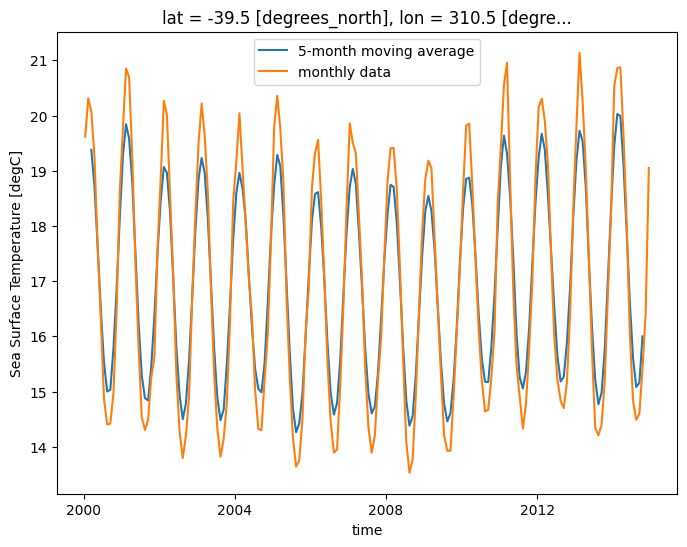

In [ ]:
lat = 50
lon = 310

m_avg.isel(lat=lat, lon=lon).plot(size=6)
ds.tos.isel(lat=lat, lon=lon).plot()
plt.legend(['5-month moving average', 'monthly data']);

## Masking Data


Masking of data can be performed in Xarray by providing single or multiple conditions to either Xarray's `.where()` method or a `Dataset` or `DataArray`'s `.where()` method. Data values matching the condition(s) are converted into a single example value, effectively masking them from the scientifically important data. In the following set of examples, we use the `.where()` method to mask various data values in the `tos` `DataArray`.

For reference, we will first print our entire sea-surface temperature (SST) dataset:

In [ ]:
ds

<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 nan nan nan nan ... -1.746 -1.746 -1.746
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

### Using `where` with one condition

In this set of examples, we are trying to analyze data at the last temporal value in the dataset. This first example illustrates the use of `.isel()` to perform this analysis:

In [ ]:
sample = ds.tos.isel(time=-1)
sample

<xarray.DataArray 'tos' (lat: 180, lon: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-1.756119, -1.756165, -1.756205, ..., -1.755922, -1.755986, -1.756058],
       [-1.750638, -1.750658, -1.750667, ..., -1.750508, -1.750561, -1.750605],
       [-1.74627 , -1.746267, -1.746261, ..., -1.746309, -1.746299, -1.746285]],
      dtype=float32)
Coordinates:
    time     object 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

As shown in the previous example, methods like `.isel()` and `.sel()` return data of a different shape than the original data provided to them. However, `.where()` preserves the shape of the original data by masking the values with a Boolean condition. Data values for which the condition is `True` are returned identical to the values passed in. On the other hand, data values for which the condition is `False` are returned as a preset example value. (This example value defaults to `nan`, but can be set to other values as well.)

Before testing `.where()`, it is helpful to look at the [official documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html). As stated above, the `.where()` method takes a Boolean condition. (Boolean conditions use operators such as less-than, greater-than, and equal-to, and return a value of `True` or `False`.) Most uses of `.where()` check whether or not specific data values are less than or greater than a constant value. As stated in the documentation, the data values specified in the Boolean condition of `.where()` can be any of the following:

- a `DataArray`
- a `Dataset`
- a function

In the following example, we make use of `.where()` to mask data with temperature values greater than `0`. Therefore, values greater than `0` are set to `nan`, as described above. (It is important to note that the Boolean condition matches values to keep, not values to mask out.)

In [ ]:
masked_sample = sample.where(sample < 0.0)
masked_sample

<xarray.DataArray 'tos' (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.7561191, -1.7561648, -1.7562052, ..., -1.7559224, -1.7559862,
        -1.7560585],
       [-1.7506379, -1.7506577, -1.7506672, ..., -1.7505083, -1.750561 ,
        -1.7506049],
       [-1.7462697, -1.7462667, -1.7462606, ..., -1.7463093, -1.746299 ,
        -1.7462848]], dtype=float32)
Coordinates:
    time     object 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

In this example, we use Matplotlib to plot the original, unmasked data, as well as the masked data created in the previous example.

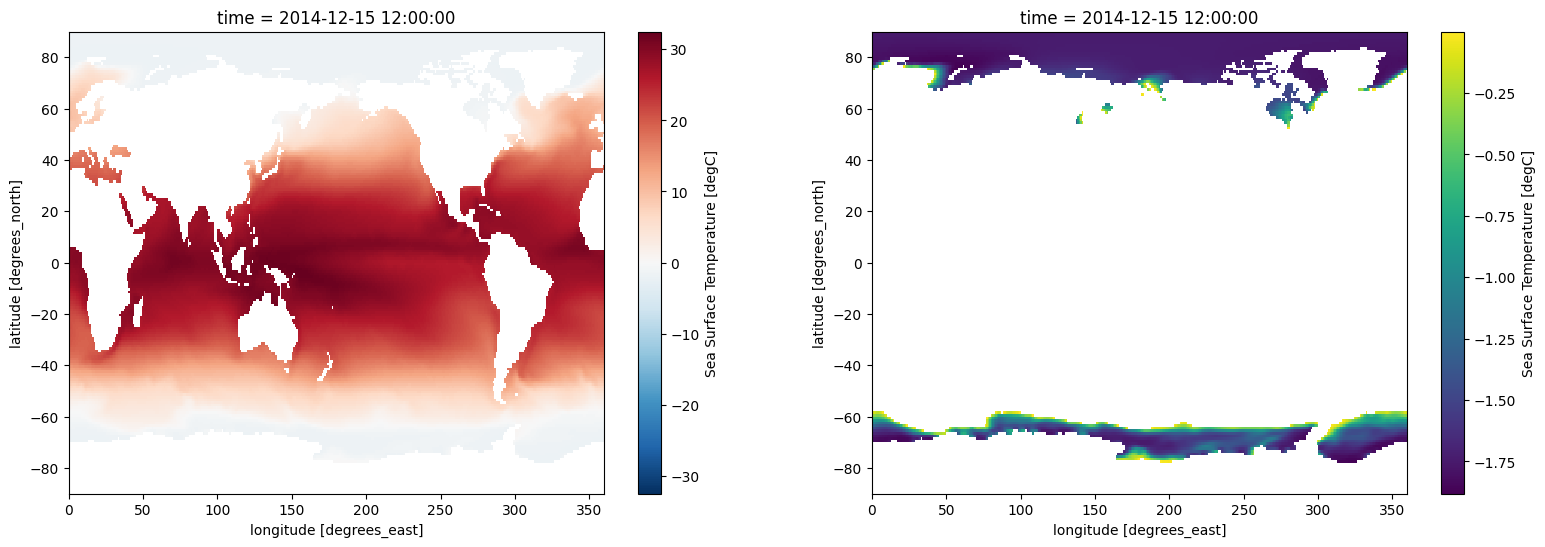

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(19, 6))
sample.plot(ax=axes[0])
masked_sample.plot(ax=axes[1]);

### Using `where` with multiple conditions

Those familiar with Boolean conditions know that such conditions can be combined by using logical operators. In the case of `.where()`, the relevant logical operators are bitwise or exclusive `'and'` (represented by the `&` symbol) and bitwise or exclusive 'or' (represented by the `|` symbol). This allows multiple masking conditions to be specified in a single use of `.where()`; however, be aware that if multiple conditions are specified in this way, each simple Boolean condition must be enclosed in parentheses. (If you are not familiar with Boolean conditions, or this section is confusing in any way, please review a detailed Boolean expression guide before continuing with the tutorial.) In this example, we provide multiple conditions to `.where()` using a more complex Boolean condition. This allows us to mask locations with temperature values less than 25, as well as locations with temperature values greater than 30. (As stated above, the Boolean condition matches values to keep, and everything else is masked out. Because we are now using more complex Boolean conditions, understanding the following example may be difficult. Please review a Boolean condition guide if needed.)

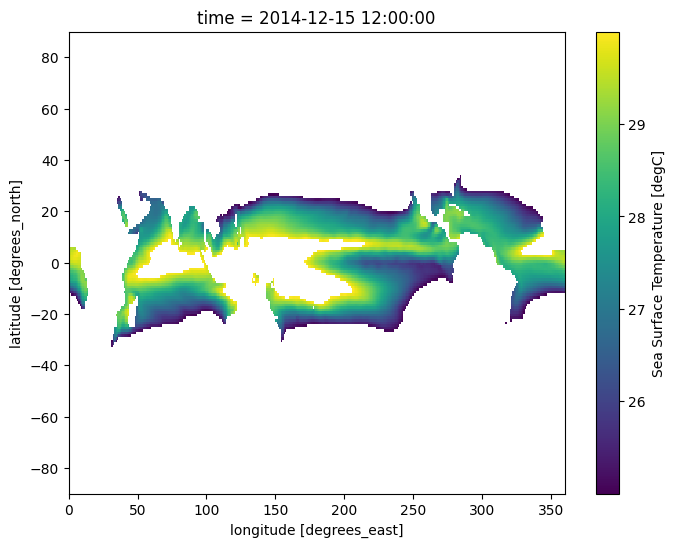

In [ ]:

sample.where((sample > 25) & (sample < 30)).plot(size=6);

In addition to using `DataArrays` and `Datasets` in Boolean conditions provided to `.where()`, we can also use coordinate variables. In the following example, we make use of Boolean conditions containing `latitude` and `longitude` coordinates. This greatly simplifies the masking of regions outside of the [Niño 3.4 region](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/):

![](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)



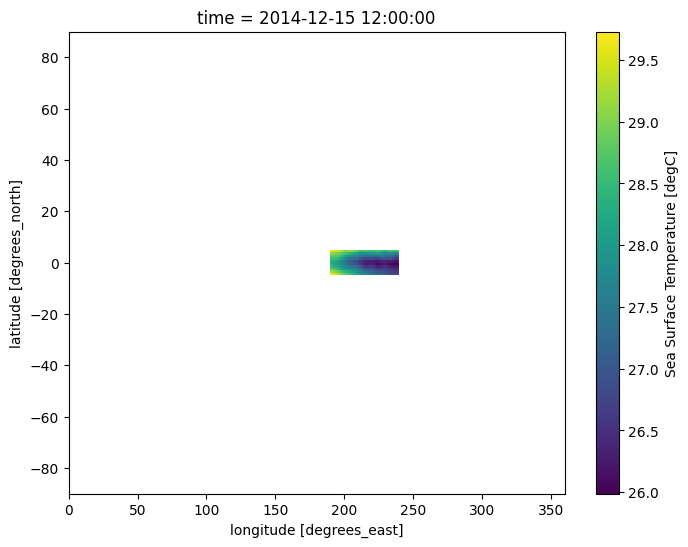

In [ ]:
sample.where(
    (sample.lat < 5) & (sample.lat > -5) & (sample.lon > 190) & (sample.lon < 240)
).plot(size=6);

### Using `where` with a custom fill value

In the previous examples that make use of `.where()`, the masked data values are set to `nan`. However, this behavior can be modified by providing a second value, in numeric form, to `.where()`; if this numeric value is provided, it will be used instead of `nan` for masked data values. In this example, masked data values are set to `0` by providing a second value of `0` to the `.where()` method:

In [ ]:
sample.where((sample > 25) & (sample < 30), 0).plot(size=6);

In [ ]:
import cartopy.crs as ccrs

# Part 3: The Niño 3.4 Index


We now a real-world example: the computation of the [Niño 3.4 Index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni), as shown in the CESM2 submission for the [CMIP6 project](https://esgf-node.llnl.gov/projects/cmip6/). A rough definition of Niño 3.4, in addition to a definition of Niño data computation, is listed below:

> Niño 3.4 (5N-5S, 170W-120W): The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Niño X Index computation: a) Compute area averaged total SST from Niño X region; b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; c) Smooth the anomalies with a 5-month running mean; d) Normalize the smoothed values by its standard deviation over the climatological period.

The overall goal of this tutorial is to produce a plot of ENSO data using Xarray; this plot will resemble the Oceanic Niño Index plot shown below.

![ONI index plot from NCAR Climate Data Guide](https://climatedataguide.ucar.edu/sites/default/files/styles/extra_large/public/2022-03/indices_oni_2_2_lg.png)

In this first example, we begin by opening datasets containing the sea-surface temperature (SST) and grid-cell size data. (These datasets are taken from the Pythia example data library, using the Pythia package imported above.) The two datasets are then combined into a single dataset using Xarray's `merge` method.

In [ ]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
data = xr.open_dataset(filepath)
filepath2 = DATASETS.fetch('CESM2_grid_variables.nc')
areacello = xr.open_dataset(filepath2).areacello

ds = xr.merge([data, areacello])
ds

/usr/local/lib/python3.10/dist-packages/xarray/conventions.py:431: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 ...
    areacello  (lat, lon) float64 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

This example uses Matplotlib and Cartopy to plot the first time slice of the dataset on an actual geographic map. By doing so, we verify that the data values fit the pattern of SST data:

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ds.tos.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
);

## Select the Niño 3.4 region

In this set of examples, we demonstrate the selection of data values from a dataset which are located in the Niño 3.4 geographic region. The following example illustrates a selection technique that uses the `sel()` or `isel()` method:

In [ ]:
tos_nino34 = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))
tos_nino34

<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 10, lon: 50)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 ...
    areacello  (lat, lon) float64 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

This example illustrates the alternate technique for selecting Niño 3.4 data, which makes use of the `where()` method:

In [ ]:
tos_nino34 = ds.where(
    (ds.lat < 5) & (ds.lat > -5) & (ds.lon > 190) & (ds.lon < 240), drop=True
)
tos_nino34

<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 10, lon: 50)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2, lat, lon) object 2000-01-01 00:00:00 ... 2015-01-01...
    lat_bnds   (lat, d2, lon) float64 -5.0 -5.0 -5.0 -5.0 ... 5.0 5.0 5.0 5.0
    lon_bnds   (lon, d2, lat) float64 190.0 190.0 190.0 ... 240.0 240.0 240.0
    tos        (time, lat, lon) float32 28.26 28.16 28.06 ... 28.54 28.57 28.63
    areacello  (lat, lon) float64 1.233e+10 1.233e+10 ... 1.233e+10 1.233e+10
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

Finally, we plot the selected region to ensure it fits the definition of the Niño 3.4 region:

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
tos_nino34.tos.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
)
ax.set_extent((120, 300, 10, -10))

## Compute the anomalies

There are three main steps to obtain the anomalies from the Niño 3.4 dataset created in the previous set of examples. First, we use the `groupby()` method to convert to monthly data. Second, we subtract the mean sea-surface temperature (SST) from the monthly data. Finally, we obtain the anomalies by computing a weighted average. These steps are illustrated in the next example:

In [ ]:
gb = tos_nino34.tos.groupby('time.month')
tos_nino34_anom = gb - gb.mean(dim='time')
index_nino34 = tos_nino34_anom.weighted(tos_nino34.areacello).mean(dim=['lat', 'lon'])

In this example, we smooth the data curve by applying a `mean` function with a 5-month moving window to the anomaly dataset. We then plot the smoothed data against the original data to demonstrate:

In [ ]:
index_nino34_rolling_mean = index_nino34.rolling(time=5, center=True).mean()

In [ ]:
index_nino34.plot(size=8)
index_nino34_rolling_mean.plot()
plt.legend(['anomaly', '5-month running mean anomaly'])
plt.title('SST anomaly over the Niño 3.4 region');

Since the ENSO index conveys deviations from a norm, the calculation of Niño data requires a standard deviation. In this example, we calculate the standard deviation of the SST in the Niño 3.4 region data, across the entire time period of the data array:

In [ ]:
std_dev = tos_nino34.tos.std()
std_dev

<xarray.DataArray 'tos' ()>
array(1.8436452, dtype=float32)

The final step of the Niño 3.4 index calculation involves normalizing the data. In this example, we perform this normalization by dividing the smoothed anomaly data by the standard deviation calculated above:

In [ ]:
normalized_index_nino34_rolling_mean = index_nino34_rolling_mean / std_dev

## Visualize the computed Niño 3.4 index

In this example, we use Matplotlib to generate a plot of our final Niño 3.4 data. This plot is set up to highlight values above 0.5, corresponding to El Niño (warm) events, and values below -0.5, corresponding to La Niña (cold) events.

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean >= 0.4
    ).data,
    0.4,
    color='red',
    alpha=0.9,
)
plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean <= -0.4
    ).data,
    -0.4,
    color='blue',
    alpha=0.9,
)

normalized_index_nino34_rolling_mean.plot(color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.title('Niño 3.4 Index');